In [94]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Device:', tpu.master())
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except:
#     strategy = tf.distribute.get_strategy()
# print('Number of replicas:', strategy.num_replicas_in_sync)
    
# print(tf.__version__)

In [2]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE
# BATCH_SIZE = 32 * strategy.num_replicas_in_sync
# IMAGE_SIZE = [176, 208]
# EPOCHS = 10

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_size = [64, 64]
batch_size = 32
epoch = 10 

In [19]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    '../Alz_data/train/',
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode='grayscale',
    image_size=image_size,
    batch_size=batch_size,
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    '../Alz_data/train',
        validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode='grayscale',
    image_size=image_size,
    batch_size=batch_size,
)

Found 2612 files belonging to 2 classes.
Using 2090 files for training.
Found 2612 files belonging to 2 classes.
Using 522 files for validation.


In [48]:
print(val_data)

<PrefetchDataset shapes: ((None, 64, 64, 1), (None, 2)), types: (tf.float32, tf.float32)>


In [20]:
train_data = train_data

In [21]:
class_names = ['ModerateDementia', 'NonDementia']
train_data.class_names = class_names
val_data.class_names = class_names

NUM_CLASSES = len(class_names)

In [22]:
# plt.figure(figsize=(10, 10))
# for images, labels in train_data.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(train_data.class_names[labels[i]])
#     plt.axis("off")

In [23]:

def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_data = train_data.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_data = val_data.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [ ]:

def cache(data):
    return data.cache().prefetch(buffer_size=AUTOTUNE)
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
#Testing AUC

In [26]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block


In [27]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [81]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
        tf.keras.Input(shape=(*image_size, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='sigmoid', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
#         conv_block(256),
#         tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
#         dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [99]:
model.summary()

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_10 (Rescaling)     (None, 64, 64, 1)         0         
_________________________________________________________________
input_11 (InputLayer)        multiple                  0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
sequential_68 (Sequential)   (None, 16, 16, 32)        2160      
_________________________________________________________________
sequential_69 (Sequential)   (None, 8, 8, 64)        

In [96]:
# with strategy.scope():
model = build_model()

METRICS = [tf.keras.metrics.AUC(name='auc')]
    
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [97]:
# def exponential_decay(lr0, s):
#     def exponential_decay_fn(epoch):
#         return lr0 * 0.1 **(epoch / s)
#     return exponential_decay_fn

# exponential_decay_fn = exponential_decay(0.1, 20)

# # lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# # checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
#                                                     save_best_only=True)

# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
#                                                      restore_best_weights=True)

In [98]:
history = model.fit(
    train_data,
    validation_data=val_data,
#     callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=epoch
)

Epoch 1/10
66/66 [==============================] - 10s 155ms/step - auc: 0.6301 - loss: 0.7703 - val_auc: 0.9751 - val_loss: 0.4240
Epoch 2/10
66/66 [==============================] - 10s 147ms/step - auc: 0.8542 - loss: 0.4810 - val_auc: 0.9751 - val_loss: 0.2769
Epoch 3/10
66/66 [==============================] - 10s 150ms/step - auc: 0.9612 - loss: 0.2885 - val_auc: 0.9751 - val_loss: 0.1710
Epoch 4/10
66/66 [==============================] - 10s 150ms/step - auc: 0.9778 - loss: 0.2009 - val_auc: 0.9751 - val_loss: 0.1240
Epoch 5/10
66/66 [==============================] - 10s 150ms/step - auc: 0.9821 - loss: 0.1511 - val_auc: 0.9751 - val_loss: 0.1175
Epoch 6/10
66/66 [==============================] - 10s 152ms/step - auc: 0.9806 - loss: 0.1318 - val_auc: 0.9751 - val_loss: 0.1199
Epoch 7/10
66/66 [==============================] - 11s 166ms/step - auc: 0.9818 - loss: 0.1199 - val_auc: 0.9751 - val_loss: 0.1328
Epoch 8/10
66/66 [==============================] - 11s 171ms/step - 

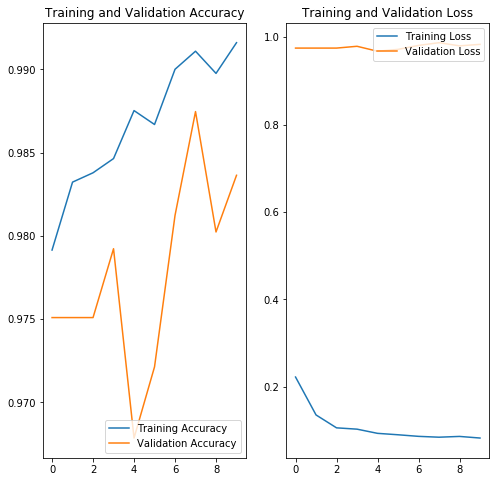

In [74]:
acc = history.history['auc']
val_acc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_auc']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [64]:
# w_standarization = model.fit(
#     train_data,
#     validation_data=val_data,
# #     callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
#     epochs=epoch
# )

In [77]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    '../Alz_data/test/',
    image_size=image_size,
    batch_size=batch_size,
)
test_data = test_data.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

Found 652 files belonging to 2 classes.


In [89]:
print(test_data)

<PrefetchDataset shapes: ((None, 64, 64, 3), (None, 2)), types: (tf.float32, tf.float32)>


In [95]:
class_names = train_data.class_names

AttributeError: 'PrefetchDataset' object has no attribute 'class_names'

In [82]:
model.evaluate(test_data)

ValueError: in user code:

    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/training.py:1208 run_step  **
        outputs = model.test_step(data)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/training.py:1174 test_step
        y_pred = self(x, training=False)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer conv2d_16 is incompatible with the layer: expected axis -1 of input shape to have value 1 but received input with shape [None, 64, 64, 3]


In [ ]:
#Testing Categorical Accuracy

In [83]:
def build_model_2():
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
        tf.keras.Input(shape=(*image_size, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [84]:

modeling = build_model_2()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')]
    
modeling.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [85]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.1, 40)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [86]:
history = modeling.fit(
    train_data,
    validation_data=val_data,
#     callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=epoch
)

Epoch 1/10
66/66 [==============================] - 12s 175ms/step - categorical_accuracy: 0.5895 - loss: 0.8190 - val_categorical_accuracy: 0.9751 - val_loss: 0.4960
Epoch 2/10
66/66 [==============================] - 11s 169ms/step - categorical_accuracy: 0.7785 - loss: 0.4652 - val_categorical_accuracy: 0.9751 - val_loss: 0.3417
Epoch 3/10
66/66 [==============================] - 11s 170ms/step - categorical_accuracy: 0.9000 - loss: 0.2958 - val_categorical_accuracy: 0.9751 - val_loss: 0.2100
Epoch 4/10
66/66 [==============================] - 11s 173ms/step - categorical_accuracy: 0.9517 - loss: 0.2058 - val_categorical_accuracy: 0.9751 - val_loss: 0.1708
Epoch 5/10
66/66 [==============================] - 11s 167ms/step - categorical_accuracy: 0.9699 - loss: 0.1485 - val_categorical_accuracy: 0.9751 - val_loss: 0.1484
Epoch 6/10
66/66 [==============================] - 11s 169ms/step - categorical_accuracy: 0.9785 - loss: 0.1275 - val_categorical_accuracy: 0.9751 - val_loss: 0.132

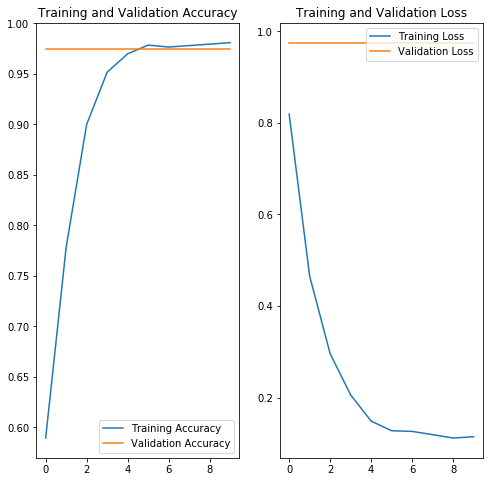

In [87]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_categorical_accuracy']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [88]:
modeling.evaluate(test_data)

ValueError: in user code:

    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/training.py:1208 run_step  **
        outputs = model.test_step(data)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/training.py:1174 test_step
        y_pred = self(x, training=False)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer conv2d_18 is incompatible with the layer: expected axis -1 of input shape to have value 1 but received input with shape [None, 64, 64, 3]


In [ ]:
#Testing Accuracy 

In [42]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
        tf.keras.Input(shape=(*image_size, 3)),
        
                
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model


In [43]:

modeling = build_model()

METRICS = [tf.keras.metrics.Accuracy(name='accuracy')]
    
modeling.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [44]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [45]:
history = modeling.fit(
    train_data,
    validation_data=val_data,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=epoch
)

Epoch 1/10


ValueError: in user code:

    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/sequential.py:386 call
        outputs = layer(inputs, **kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/input_spec.py:196 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer conv2d_6 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: [None, 64]


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_accuracy']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Testing Precision

In [46]:
modeling = build_model()

METRICS = [tf.keras.metrics.Precision(name='precision')]
    
modeling.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [47]:
history = modeling.fit(
    train_data,
    validation_data=val_data,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=epoch
)

Epoch 1/10


ValueError: in user code:

    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/sequential.py:386 call
        outputs = layer(inputs, **kwargs)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/input_spec.py:196 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer conv2d_8 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: [None, 64]


In [ ]:
acc = history.history['precision']
val_acc = history.history['val_precision']

loss = history.history['loss']
val_loss = history.history['val_precision']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
        tf.keras.Input(shape=(*image_size, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(200, 0.7),
        dense_block(120, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model


In [ ]:
modeling = build_model()

METRICS = [tf.keras.metrics.Precision(name='precision')]
    
modeling.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [ ]:
history = modeling.fit(
    train_data,
    validation_data=val_data,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=epoch
)

In [ ]:
acc = history.history['precision']
val_acc = history.history['val_precision']

loss = history.history['loss']
val_loss = history.history['val_precision']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
modeling.evaluate(test_data)

In [ ]:
cnn_model = Sequential([
    Conv2D(filters=32,kernel_size=3,activation='relu',input_shape = image_size),
    MaxPooling2D(pool_size=2) ,# down sampling the output instead of 28*28 it is 14*14
    Dropout(0.2),
    Flatten(), # flatten out the layers
    Dense(32,activation='relu'),
    Dense(10,activation = 'softmax')
    
])

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.Input(shape=(*image_size, 3)),
    tf.keras.layers.Flatten(input_shape=(64,64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])



model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])

simple = model.fit(train_data, validation_data=val_data, epochs=epoch)

test_loss, test_acc = model.evaluate(train_data)

print('\nTest accuracy:', test_acc)

In [ ]:
def create_model(input_size, n_categories):
    """
    Create a simple baseline CNN
    Args:
        input_size (tuple(int, int, int)): 3-dimensional size of input to model
        n_categories (int): number of classification categories
    Returns:
        keras Sequential model: model with new head
        """

    nb_filters = 32
    kernel_size = (3, 3)
    pool_size = (2, 2)

    model = Sequential()
    # 2 convolutional layers followed by a pooling layer followed by dropout
    model.add(Convolution2D(nb_filters, kernel_size,
                            padding='valid',
                            input_shape=input_size))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filters, kernel_size))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.25))
    # transition to an mlp
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_categories))
    model.add(Activation('softmax'))
    return model

In [ ]:
simple = create_

In [ ]:
model = keras.Sequential()
model.add(keras.Input(shape=(, 3)))  # 250x250 RGB images
model.add(layers.Conv2D(32, 5, strides=2, activation="relu"))
model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.MaxPooling2D(3))

# Can you guess what the current output shape is at this point? Probably not.
# Let's just print it:
model.summary()

# The answer was: (40, 40, 32), so we can keep downsampling...

model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.MaxPooling2D(2))

# And now?
model.summary()

# Now that we have 4x4 feature maps, time to apply global max pooling.
model.add(layers.GlobalMaxPooling2D())

# Finally, we add a classification layer.
model.add(layers.Dense(10))